In [40]:
import numpy as np
import healpy as hp
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# Display interactive plots embedded within the notebook
%matplotlib notebook

In [2]:
def objective_function(w, C):
    """Objective function: variance of the combined map."""
    return w.T @ C @ w

def gradient(w, C):
    """Gradient of the objective function."""
    return 2 * C @ w

def barzilai_borwein_ilc(C, max_iter=10000, tol=1e-9):
    """
    Calculate ILC weights using the Barzilai-Borwein method.
    
    Args:
        C (np.ndarray): Covariance matrix of the maps.
        max_iter (int): Maximum number of iterations.
        tol (float): Convergence tolerance.
    
    Returns:
        w (np.ndarray): Optimized weights.
    """
    n = C.shape[0]
    
    # Initial weights (equal weights)
    w = np.ones(n) / n
    
    # Initial gradient
    g = gradient(w, C)  

    # Initialize alpha with a small value (based on the initial gradient)
    alpha = 1.0 / np.linalg.norm(g)

    for i in range(max_iter):
        # Update weights
        w_new = w - alpha * g
        
        # Update gradient
        g_new = gradient(w_new, C)

        # Enforce normalization of the weight vector
        w_new /= w_new.sum()

        # Update step size
        dw = w_new - w
        dg = g_new - g
        
        # Update for next iteration
        w = w_new
        g = g_new
        alpha = (dw.T @ dg) / (dg.T @ dg)

        # Check for convergence
        if np.linalg.norm(dw) < tol:
            print(f"Barzilai-Borwein method converged after {i+1} iterations.")
            break

    return w

In [3]:
# Load the frequency maps
maps = []

for i in range(5):
    hdu = fits.open(f'map{i+1}.fits')  # Load each map
    maps.append(hdu[0].data)           # Store the data
    hdu.close()
    
np.shape(maps)

(5, 1024, 2048)

In [4]:
shape = np.shape(maps)

maps_reshaped  = np.reshape(maps, (shape[0], shape[1]*shape[2]))

np.shape(maps_reshaped)

(5, 2097152)

In [5]:
# Mask pixels with NaN to compute covariance matrix
masked_maps = maps_reshaped[:,~np.isnan(maps_reshaped).any(axis=0)]

np.shape(masked_maps)

(5, 1050376)

In [6]:
# Compute the covariance matrix of the maps
cov_matrix = np.cov(masked_maps)

np.shape(cov_matrix)

(5, 5)

In [7]:
# Calculate ILC weights using the Barzilai-Borwein method
weights = barzilai_borwein_ilc(cov_matrix)

print("Weight vector: ",weights)
print("Sum of weights: ",sum(weights))

Barzilai-Borwein method converged after 633 iterations.
Weight vector:  [0.00856456 0.05518594 0.26532724 0.55111688 0.11980539]
Sum of weights:  1.0


In [8]:
# Combine the maps using the ILC weights
output_map = np.sum(weights[:, np.newaxis, np.newaxis] * maps, axis=0)

np.shape(output_map)

(1024, 2048)

In [16]:
#CMB COLORMAP AVAILABLE FROM https://github.com/zonca/paperplots/raw/master/data/Planck_Parchment_RGB.txt
planck_cmap = ListedColormap(np.loadtxt("Planck_Parchment_RGB.txt")/255.)
planck_cmap.set_bad("gray")    #MISSING PIXELS
planck_cmap.set_under("white") #BACKGROUND

<IPython.core.display.Javascript object>


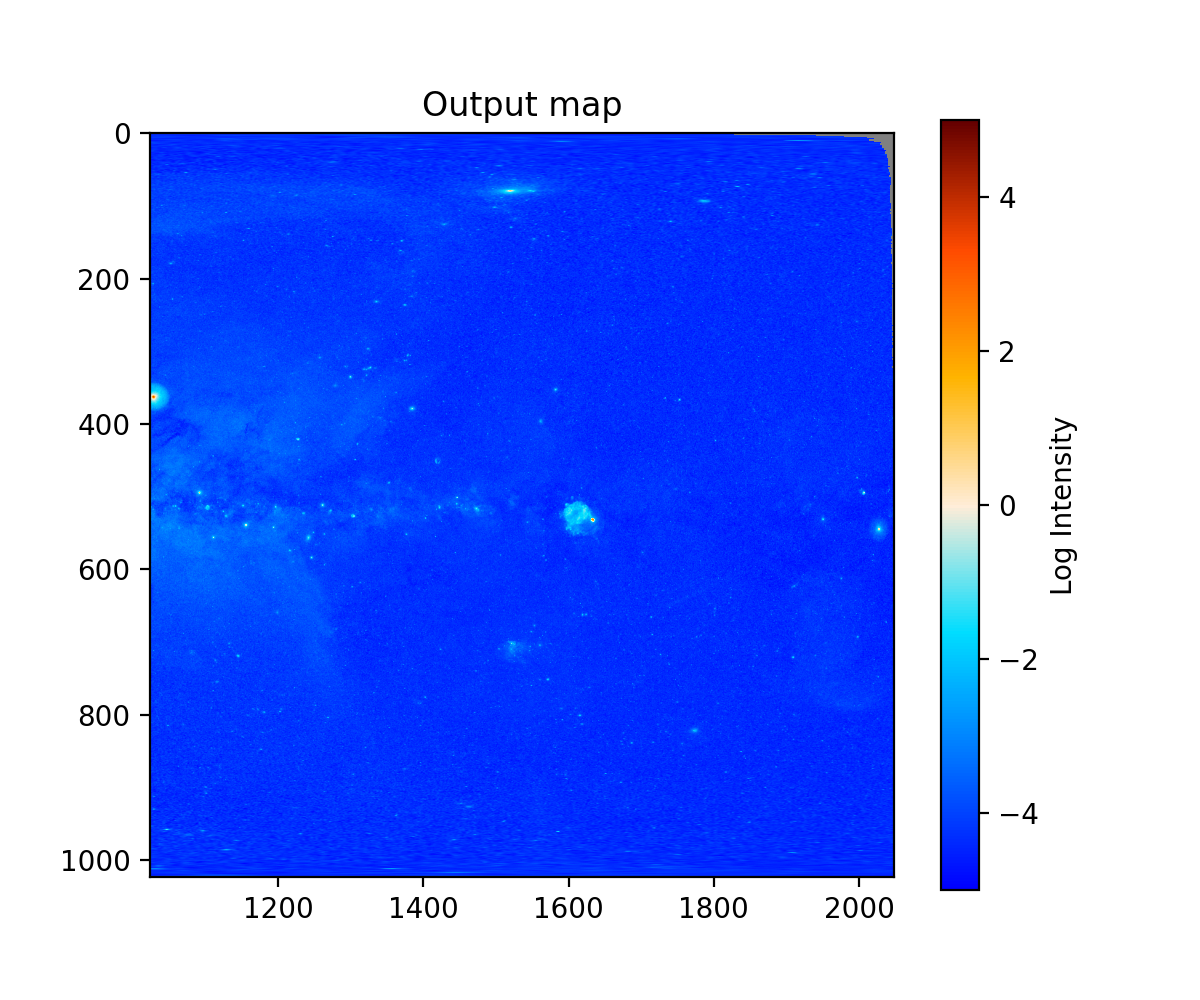

In [117]:
# Visualize the extracted CMB map
plt.figure(figsize=(6, 5))
plt.imshow(np.log(output_map), origin='upper', cmap=planck_cmap)
ax = plt.gca()
ax.set_xlim([1024, 2048])
plt.colorbar(label='Log Intensity')
plt.clim(-5,5)
plt.title('Output map')
plt.show()
# plt.savefig('output_map.pdf', dpi=1200, bbox_inches='tight')

<IPython.core.display.Javascript object>


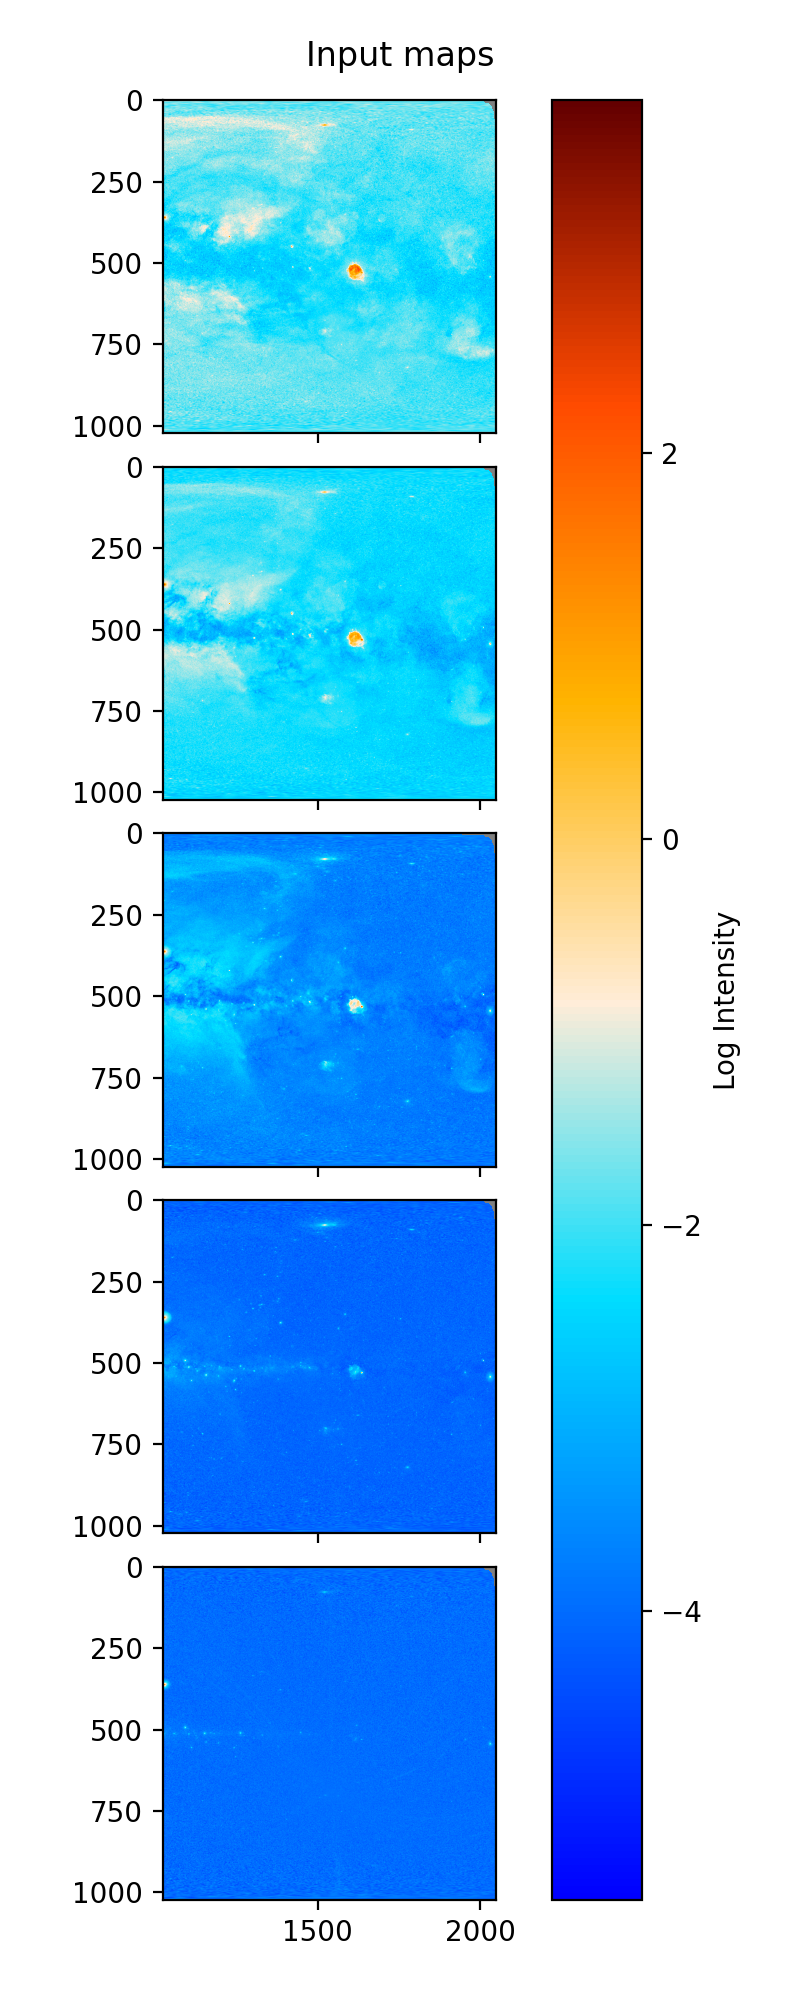

RuntimeError: You must first define an image, e.g., with imshow

In [119]:
fig, axes = plt.subplots(nrows=5, sharex=True, figsize=(4,10))
fig.suptitle('Input maps')

for i, ax in enumerate(axes.flat):
    im = ax.imshow(np.log(maps[i][:][:]), origin='upper', cmap=planck_cmap)
    ax.set_xlim([1024, 2048])
    
fig.subplots_adjust(top=0.95, bottom=0.05, left=-0.5, hspace=0.1)
fig.colorbar(im, ax=axes.ravel().tolist(), label='Log Intensity')
plt.show()
# plt.savefig('input_maps.pdf', dpi=1200, bbox_inches='tight')